<a href="https://colab.research.google.com/github/harshadindigal/PythonProjects/blob/master/var_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install pandas statsmodels requests matplotlib


            GLD  SLV       SPY  TLT  AGG    XLK
1999-11-01  NaN  NaN  135.5625  NaN  NaN  42.44
1999-11-02  NaN  NaN  134.5937  NaN  NaN  42.25
1999-11-03  NaN  NaN  135.5000  NaN  NaN  42.88
1999-11-04  NaN  NaN  136.5312  NaN  NaN  43.20
1999-11-05  NaN  NaN  137.8750  NaN  NaN  43.67
            GLD  SLV        SPY  TLT  AGG       XLK
1999-11-01  NaN  NaN  4006500.0  NaN  NaN  230800.0
1999-11-02  NaN  NaN  6516900.0  NaN  NaN  156300.0
1999-11-03  NaN  NaN  7222300.0  NaN  NaN  209200.0
1999-11-04  NaN  NaN  7907500.0  NaN  NaN  409100.0
1999-11-05  NaN  NaN  7431500.0  NaN  NaN  898000.0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 24, Jun, 2024
Time:                     05:05:17
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                    188.953
Nobs:                     4559.00    HQIC:                   187.758
Log likelihood:          -502835.    FPE:                1.82204e+81
AIC:                      187.109    Det(Omega_mle):     1.37222e+81
--------------------------------------------------------------------
Results for equation GLD_price
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -1.756929         1.055125           -1.665           0.096
L1.GLD_price          0.978459         0.015938           61.393           0.000
L1.SLV_price          0.001234         0.008428         

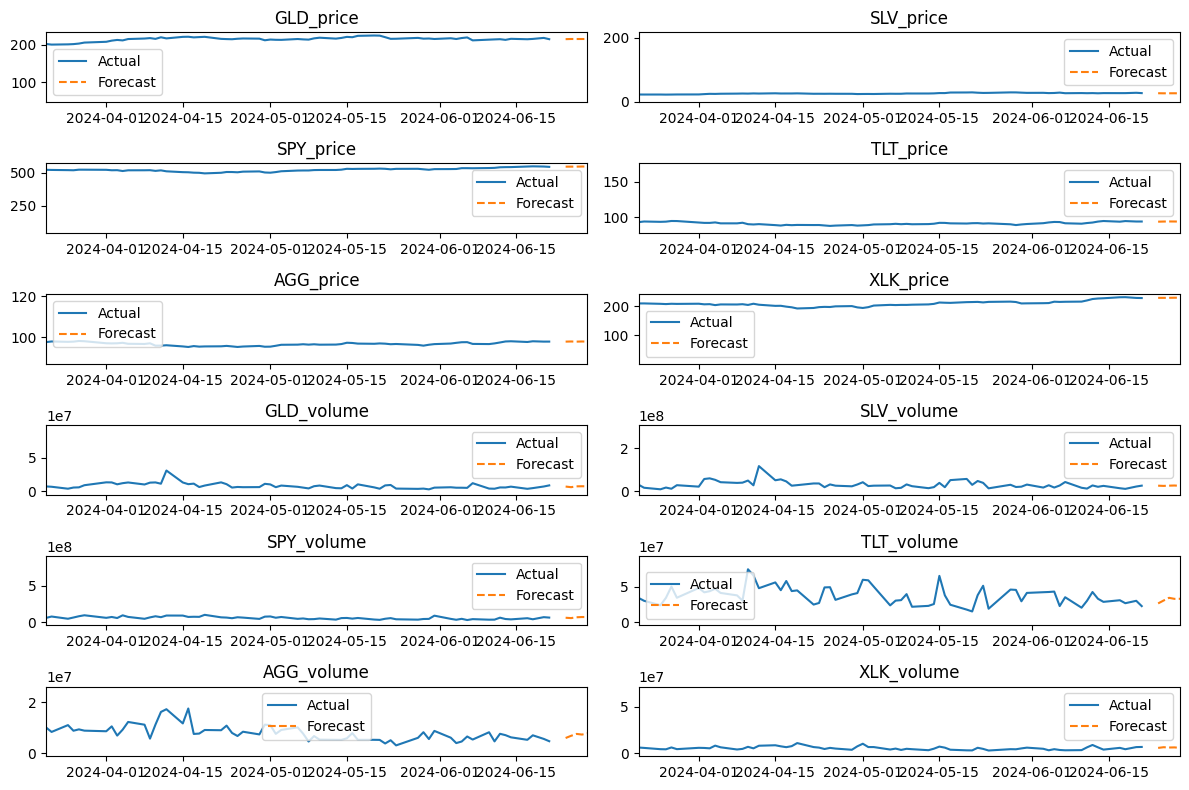

In [7]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

def fetch_alpha_vantage_data(symbol, api_key):
    url = f'https://www.alphavantage.co/query'
    params = {
        'function': 'TIME_SERIES_DAILY',
        'symbol': symbol,
        'outputsize': 'full',
        'apikey': api_key
    }
    response = requests.get(url, params=params)
    data = response.json()
    time_series_key = 'Time Series (Daily)'
    if time_series_key in data:
        df = pd.DataFrame(data[time_series_key]).T
        df = df.rename(columns={
            '1. open': 'open',
            '2. high': 'high',
            '3. low': 'low',
            '4. close': 'close',
            '5. volume': 'volume'
        }).astype(float)
        df.index = pd.to_datetime(df.index)
        return df
    else:
        raise ValueError(f"Error fetching data for symbol {symbol}: {data}")

api_key = 'DX4WHV2HIKPO1GI8.'

symbols = ['GLD', 'SLV', 'SPY', 'TLT', 'AGG', 'XLK']
data = {}

for symbol in symbols:
    data[symbol] = fetch_alpha_vantage_data(symbol, api_key)

# Combine the data into a single DataFrame
combined_data = pd.DataFrame({symbol: data[symbol]['close'] for symbol in symbols})
combined_volume = pd.DataFrame({symbol: data[symbol]['volume'] for symbol in symbols})

# Ensure the data is sorted by date
combined_data = combined_data.sort_index()
combined_volume = combined_volume.sort_index()

# Display the combined data
print(combined_data.head())
print(combined_volume.head())

# Merge price and volume data
merged_data = combined_data.join(combined_volume, lsuffix='_price', rsuffix='_volume')

# Drop rows with missing values
merged_data = merged_data.dropna()

# Fit the VAR model
model = VAR(merged_data)
results = model.fit(maxlags=15, ic='aic')

# Summary of the model
print(results.summary())

# Forecasting
lag_order = results.k_ar
forecast_input = merged_data.values[-lag_order:]
forecast = results.forecast(y=forecast_input, steps=5)
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=merged_data.index[-1] + pd.Timedelta(days=1), periods=5, freq='B'), columns=merged_data.columns)

# Plotting the last 3 months + forecast
last_3_months = merged_data.index[-1] - pd.DateOffset(months=3)
plt.figure(figsize=(12, 8))

for i, column in enumerate(merged_data.columns, 1):
    plt.subplot(len(merged_data.columns) // 2, 2, i)
    plt.plot(merged_data.index, merged_data[column], label='Actual')
    plt.plot(forecast_df.index, forecast_df[column], label='Forecast', linestyle='--')
    plt.title(f'{column}')
    plt.xlim(last_3_months, forecast_df.index[-1])  # Limit x-axis to last 3 months + forecast
    plt.legend()

plt.tight_layout()
plt.show()


In [9]:
# Assuming forecast_df is already generated from the VAR model forecast

# Calculate the expected return as a percentage for each asset
forecast_returns = (forecast_df.iloc[-1] / merged_data.iloc[-1] - 1) * 100

# Sort assets by expected return (descending)
recommended_assets = forecast_returns.sort_values(ascending=False)

# Print recommended assets based on expected return
# Calculate the expected return as a percentage for each asset
forecast_returns = (forecast_df.iloc[-1] / merged_data.iloc[-1] - 1) * 100

# Sort assets by expected return (descending)
recommended_assets = forecast_returns.sort_values(ascending=False)

# Print recommended assets based on expected return
print("Recommended assets to buy:")
for symbol in recommended_assets.index:
    expected_return = forecast_returns.loc[symbol]
    print(f"{symbol}: Expected return {expected_return:.2f}%")


Recommended assets to buy:
AGG_volume: Expected return 65.63%
TLT_volume: Expected return 44.89%
SPY_volume: Expected return 12.23%
SPY_price: Expected return 0.47%
XLK_price: Expected return 0.44%
GLD_price: Expected return 0.18%
AGG_price: Expected return -0.03%
TLT_price: Expected return -0.09%
SLV_price: Expected return -2.27%
SLV_volume: Expected return -3.55%
XLK_volume: Expected return -14.75%
GLD_volume: Expected return -15.13%
